In [1]:
!pip -q install tensorflow==2.16.1 tensorflow-datasets==4.9.4 Pillow matplotlib

In [2]:
# Imports & config
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 3
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)

In [3]:
#  Download and extract the clean dataset
url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
zip_path = tf.keras.utils.get_file("cats_and_dogs_filtered.zip", origin=url, extract=False)

# Extract it
extract_dir = os.path.join(os.path.dirname(zip_path), "cats_and_dogs_filtered")
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(os.path.dirname(zip_path))

train_dir = os.path.join(extract_dir, "train")
val_dir = os.path.join(extract_dir, "validation")

print("Dataset extracted to:", extract_dir)

Dataset extracted to: C:\Users\Silvia Petrova\.keras\datasets\cats_and_dogs_filtered


In [4]:
# Load datasets 
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary',
    seed=SEED
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary',
    seed=SEED
)

class_names = train_ds_raw.class_names

# Normalize datasets
train_ds = train_ds_raw.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).prefetch(AUTOTUNE)
val_ds = val_ds_raw.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).prefetch(AUTOTUNE)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


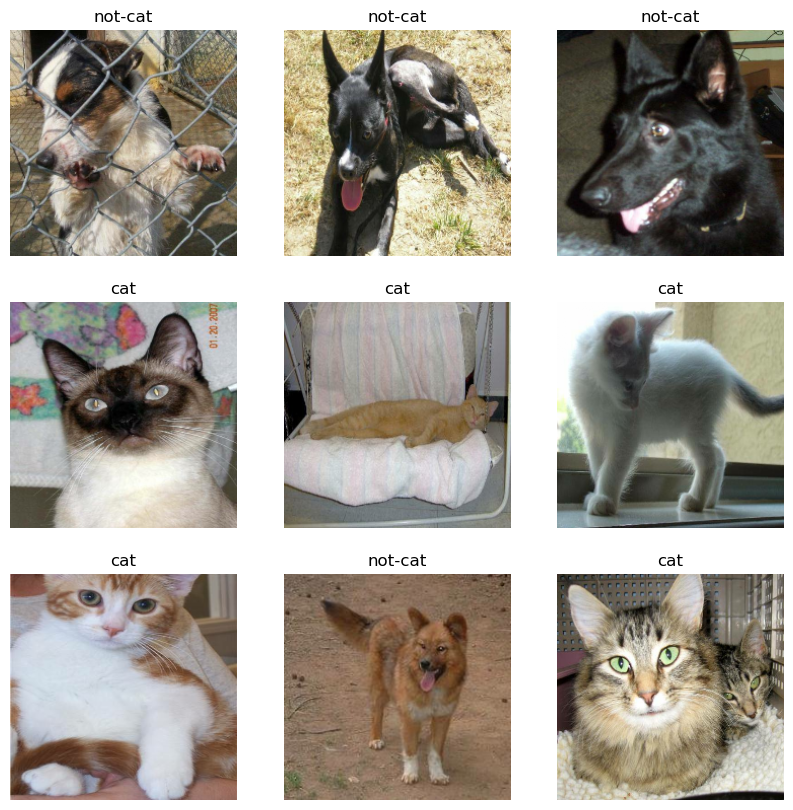

In [5]:
# example images and labels
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        label = "cat" if labels[i].numpy() == 0 else "not-cat"
        plt.title(label)
        plt.axis("off")

In [6]:
# Build the model (using MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
# Train the model
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 750ms/step - accuracy: 0.8895 - auc: 0.9599 - loss: 0.2799 - val_accuracy: 0.9870 - val_auc: 0.9990 - val_loss: 0.0816
Epoch 2/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 678ms/step - accuracy: 0.9825 - auc: 0.9975 - loss: 0.0770 - val_accuracy: 0.9870 - val_auc: 0.9992 - val_loss: 0.0543
Epoch 3/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 674ms/step - accuracy: 0.9840 - auc: 0.9981 - loss: 0.0598 - val_accuracy: 0.9910 - val_auc: 0.9996 - val_loss: 0.0416


In [8]:
#  Fine-tune the last 30 layers 
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

model.fit(train_ds, epochs=1, validation_data=val_ds)

63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 799ms/step - accuracy: 0.9645 - auc: 0.9948 - loss: 0.0910 - val_accuracy: 0.9940 - val_auc: 0.9998 - val_loss: 0.0163


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


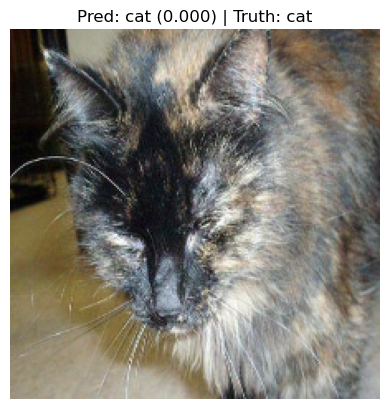

In [9]:
# Test the model on validation image
for images, labels in val_ds.take(1):
    img = images[0]
    true_label = "cat" if labels[0].numpy() == 0 else "not-cat"
    pred_prob = float(model.predict(img[None, ...])[0][0])
    pred_label = "cat" if pred_prob < 0.5 else "not-cat"

    plt.imshow(img.numpy())
    plt.title(f"Pred: {pred_label} ({pred_prob:.3f}) | Truth: {true_label}")
    plt.axis("off")
    plt.show()

In [10]:
# test the model
def predict_on_custom_image(image_path):
    img = Image.open(image_path).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
    arr = np.asarray(img).astype("float32") / 255.0
    pred = float(model.predict(arr[None, ...])[0][0])
    label = "cat" if pred < 0.5 else "not-cat"
    plt.imshow(arr)
    plt.title(f"Prediction: {label} ({pred:.3f})")
    plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


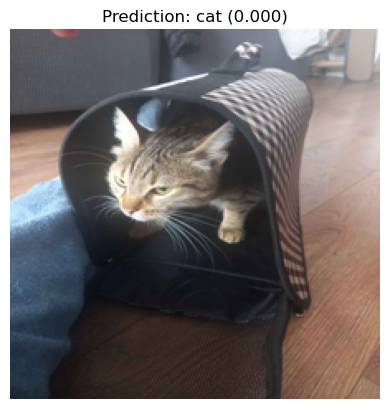

In [11]:
image_path = "C:\\Users\\Silvia Petrova\\Pictures\\CAT.jpg"  
predict_on_custom_image(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


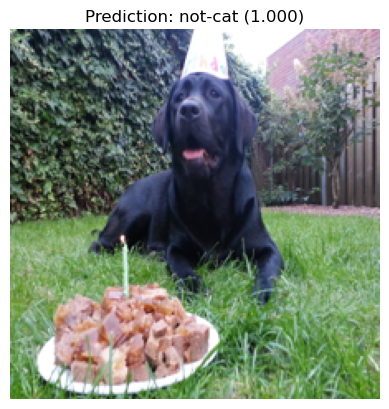

In [12]:
image_path2 = "C:\\Users\\Silvia Petrova\\Pictures\\ot fb\\10387024_844605998904310_7884892966543349118_o.jpg" 
predict_on_custom_image(image_path2)